# Preprocessing Steam Games

## Import Libraries

In [1334]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MultiLabelBinarizer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings('ignore')

import ast
from collections import Counter
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

from numpy import unique
from scipy.stats import skew

## Load Data

In [1335]:
# Define file paths
DEMOS_PATH = '../../data/raw/demos.csv'
DLCS_PATH = '../../data/raw/dlcs.csv'
BASE_GAMES_PATH = '../../data/raw/info_base_games.csv'
GAMALYTIC_STEAM_GAMES = '../../data/raw/gamalytic_steam_games.csv'
OUTPUT_PATH = '../../data/processed/processed_data.csv'

# Read CSV files
demo_df = pd.read_csv(DEMOS_PATH)
dlc_df = pd.read_csv(DLCS_PATH)
info_base_games_df = pd.read_csv(BASE_GAMES_PATH, low_memory=False)
gamalytic_steam_games_df = pd.read_csv(GAMALYTIC_STEAM_GAMES)

## Explore Data

In [1336]:
print(info_base_games_df.shape)
print(gamalytic_steam_games_df.shape)
print(demo_df.shape)
print(dlc_df.shape)

print("Info Base Games File Columns:", info_base_games_df.columns.tolist())
print("Gamalytic Steam Games File Columns:", gamalytic_steam_games_df.columns.tolist())
print("Demo File Columns:", demo_df.columns.tolist())
print("DLC File Columns:", dlc_df.columns.tolist())

(99167, 10)
(93338, 6)
(15449, 4)
(5445, 3)
Info Base Games File Columns: ['appid', 'name', 'metacritic', 'steam_achievements', 'steam_trading_cards', 'workshop_support', 'genres', 'achievements_total', 'release_date', 'supported_platforms']
Gamalytic Steam Games File Columns: ['steamId', 'price', 'copiesSold', 'publisherClass', 'reviewScore', 'aiContent']
Demo File Columns: ['Unnamed: 0', 'full_game_appid', 'demo_appid', 'name']
DLC File Columns: ['base_appid', 'dlc_appid', 'name']


## Preprocessing DLCs and Demos Csv

### Statistics Before Preprocessing

In [1337]:
demo_df.info()
dlc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15449 entries, 0 to 15448
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       15449 non-null  int64 
 1   full_game_appid  15449 non-null  object
 2   demo_appid       15449 non-null  object
 3   name             15448 non-null  object
dtypes: int64(1), object(3)
memory usage: 482.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5445 entries, 0 to 5444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   base_appid  5445 non-null   object
 1   dlc_appid   5445 non-null   object
 2   name        5445 non-null   object
dtypes: object(3)
memory usage: 127.7+ KB


### Preprocessing

#### Drop auto_incremented columns

In [1338]:
demo_df.drop("Unnamed: 0", axis=1, inplace=True)

print("Demo File Columns:", demo_df.columns.tolist())
print("DLC File Columns:", dlc_df.columns.tolist())

Demo File Columns: ['full_game_appid', 'demo_appid', 'name']
DLC File Columns: ['base_appid', 'dlc_appid', 'name']


#### Standardize column names

In [1339]:
demo_df.rename(columns={"full_game_appid": "appid"}, inplace=True)
dlc_df.rename(columns={"base_appid": "appid"}, inplace=True)

print("\nAfter Standardizing Column Names:\n")
print("Demo File Columns:", demo_df.columns.tolist())
print("DLC File Columns:", dlc_df.columns.tolist())


After Standardizing Column Names:

Demo File Columns: ['appid', 'demo_appid', 'name']
DLC File Columns: ['appid', 'dlc_appid', 'name']


#### Handle missing values

In [1340]:
original_len_demo = len(demo_df)
original_len_dlc = len(dlc_df)
demo_df.dropna(inplace=True)
dlc_df.dropna(inplace=True)

print(f"Dropped {original_len_demo - len(demo_df)} rows in Demo DataFrame due to missing values.")
print(f"Remaining rows in Demo DataFrame: {len(demo_df)}\n")
print(f"Dropped {original_len_dlc - len(dlc_df)} rows in DLC DataFrame due to missing values.")
print(f"Remaining rows in DLC DataFrame: {len(dlc_df)}")

Dropped 1 rows in Demo DataFrame due to missing values.
Remaining rows in Demo DataFrame: 15448

Dropped 0 rows in DLC DataFrame due to missing values.
Remaining rows in DLC DataFrame: 5445


#### Convert data types

- errors="coerce" means that if a value cannot be converted to a number **"id is not a number"** it's replaced by NaN
- It then gets removed by dropna() function

In [1341]:
original_len_demo = len(demo_df)
original_len_dlc = len(dlc_df)

for df, appid_col in [(demo_df, "demo_appid"), (dlc_df, "dlc_appid")]:
    df[appid_col] = pd.to_numeric(df[appid_col], errors="coerce") 
    df["appid"] = pd.to_numeric(df["appid"], errors="coerce")

    # Drop rows where appid or demo/dlc_appid is missing/NaN
    df.dropna(subset=[appid_col, "appid"], inplace=True)

    df[appid_col] = df[appid_col].astype(int)
    df["appid"] = df["appid"].astype(int)
    df["name"] = df["name"].astype(str)

print(f"Dropped {original_len_demo - len(demo_df)} rows in Demo DataFrame due to missing values.")
print(f"Remaining rows in Demo DataFrame: {len(demo_df)}\n")
print(f"Dropped {original_len_dlc - len(dlc_df)} rows in DLC DataFrame due to missing values.")
print(f"Remaining rows in DLC DataFrame: {len(dlc_df)}")


Dropped 1 rows in Demo DataFrame due to missing values.
Remaining rows in Demo DataFrame: 15447

Dropped 1 rows in DLC DataFrame due to missing values.
Remaining rows in DLC DataFrame: 5444


#### Remove duplicates by unique identifier

- **demo_appid**: In the DEMOs file
- **dlc_appid**: In the DLCs file

In [1342]:
demo_duplicates = demo_df.duplicated(subset=["demo_appid"]).sum()
dlc_duplicates = dlc_df.duplicated(subset=["dlc_appid"]).sum()
demo_df.drop_duplicates(subset=["demo_appid"], inplace=True)
dlc_df.drop_duplicates(subset=["dlc_appid"], inplace=True)
print(f"Dropped {demo_duplicates} duplicate rows in Demo DataFrame based on demo_appid.")
print(f"Dropped {dlc_duplicates} duplicate rows in DLC DataFrame based on dlc_appid.")

Dropped 0 duplicate rows in Demo DataFrame based on demo_appid.
Dropped 0 duplicate rows in DLC DataFrame based on dlc_appid.


#### Clean the 'name' column

- By removing any leading or trailing whitespace from the 'name' column.
- By removing any non-alphanumeric characters from the 'name' column.
- By removing 'Demo' and 'DLC' from the 'name' column.

In [1343]:
def clean_name_column(df, column_name):
    df[column_name] = (df[column_name]
                      .str.replace(r"(?i)\bdemo\b", "", regex=True)
                      .str.replace(r"(?i)\bdlc\b", "", regex=True)
                      .str.replace(r"\s+", " ", regex=True)
                      .str.strip()
                      .str.title())
    return df

demo_df = clean_name_column(demo_df, "name")
dlc_df = clean_name_column(dlc_df, "name")

#### Reset Indicies

- Reset the indices of the dataframe to the original order.

In [1344]:
demo_df.reset_index(drop=True, inplace=True)
dlc_df.reset_index(drop=True, inplace=True)

### Extracting new features

#### Create indicator and count features

In [1345]:
def create_indicator_features(df, group_by_col, count_col, feature_prefix):

    # group by appid to count the demo/dlc count for each game 
    indicators = df.groupby(group_by_col)[count_col].count().reset_index()
    
    # create has_feature column
    indicators[f'has_{feature_prefix}'] = 1

    # create count column
    indicators[f'{feature_prefix}_count'] = indicators[count_col]
    
    # e.g.: return demo_df[['appid', 'has_demo', 'demo_count']]  
    return indicators[[group_by_col, f'has_{feature_prefix}', f'{feature_prefix}_count']]

demo_indicators = create_indicator_features(demo_df, 'appid', 'demo_appid', 'demo')
dlc_indicators = create_indicator_features(dlc_df, 'appid', 'dlc_appid', 'dlc')

#### Save the preprocessed data

- Used to save the preprocessed data to a file for testing and validation purposes.
- It's also used to add 4 features to the info_base_games: 
    
    - dlc count
    - demo count
    - dlc indicator
    - demo indicator
    

In [1346]:
# demo_df.to_csv(DEMO_OUTPUT_PATH, index=False)
# dlc_df.to_csv(DLC_OUTPUT_PATH, index=False)

### Statistics After Preprocessing

In [1347]:
demo_df.info()
dlc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15447 entries, 0 to 15446
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   appid       15447 non-null  int64 
 1   demo_appid  15447 non-null  int64 
 2   name        15447 non-null  object
dtypes: int64(2), object(1)
memory usage: 362.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5444 entries, 0 to 5443
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   appid      5444 non-null   int64 
 1   dlc_appid  5444 non-null   int64 
 2   name       5444 non-null   object
dtypes: int64(2), object(1)
memory usage: 127.7+ KB


### Summary

In [1348]:
print("\nPreprocessing Summary:\n")
print(f"Demo DataFrame: {len(demo_df)} rows, {len(demo_df.columns)} columns")
print(f"DLC DataFrame: {len(dlc_df)} rows, {len(dlc_df.columns)} columns\n")
print(f"Info_base_games DataFrame: {len(info_base_games_df)} rows, {len(info_base_games_df.columns)} columns\n")

print(dlc_df.head())
print("\n")
print(demo_df.head())
print("\n")
print(info_base_games_df.head())


Preprocessing Summary:

Demo DataFrame: 15447 rows, 3 columns
DLC DataFrame: 5444 rows, 3 columns

Info_base_games DataFrame: 99167 rows, 10 columns

     appid  dlc_appid                                             name
0  1786750    2568660                        家出王女 - 全年齢版ストーリー&グラフィック追加
1  1981700    2563730                           Jacob'S Quest - Voyage
2  2009450    2552980  Invector: Rhythm Galaxy - Latin Power Song Pack
3  1133420    2550750         Hero Or Villain: Genesis — Supercharged!
4  2533950    2551000            Hot And Lovely ：Uniform - Adult Patch


     appid  demo_appid                    name
0  2214650     2573370          Rolando Deluxe
1  1439980     2573460  Outrunner: Neon Nights
2  2412240     2572840     Bubble Ghost Remake
3  2448830     2572240           Time Handlers
4  2379590     2570800    Hope'S Final Defense


     appid                      name metacritic  steam_achievements  \
0  2574000            Femboy Burgers        NaN                Tru

## Preprocessing Base Game Info CSV

### Preprocessing Achievments and Release Date columns

#### **Preprocessing release date feature**

In [1349]:
#info_base_games_df
#print(info_base_games_df.shape)
#info_base_games_df.describe()

info_base_games_df['release_date'].isnull().sum()
#pd.set_option('display.max_rows', None)
#info_base_games_df['release_date'].value_counts()

#(info_base_games_df['release_date'] == "Coming soon").sum()  
#(info_base_games_df['release_date'] == "to be announced").sum() 
#keywords = ['vr', 'remaster', 'collector', 'collection', 'edition', 'bundle', 'playtest']
#pattern = r'\b(' + '|'.join(re.escape(k) for k in keywords) + r')\b'  # Escaping protects against regex special chars
#info_base_games_df[info_base_games_df['name'].str.contains(pattern, regex=True, flags=re.IGNORECASE)]

np.int64(306)

In [1350]:
#If there are no parentheses in pattern, .groups() returns an empty tuple.
info_base_games_df.dropna(subset=['release_date'],inplace=True)
info_base_games_df['release_date'] = info_base_games_df['release_date'].astype(str).str.strip().str.lower() # to remove any leading or trailing spaces if exist

YEAR_DATA_COLLECTED = 2024
# ^: start of string , $: end of string
unknown_release_dates = [
    r'^coming soon$',
    r'^to be announced$',
    r'^\s*$',  # empty string
    r'^q[1-4][^a-zA-Z0-9]+\d{4}$', #q2 2025
    r'\d{4}$',  # year only
    r'^\d{1,2}[^a-zA-Z0-9]+[A-Za-z]{3}$' # DAY MONTH
]
def has_known_release(x):
    x = str(x).strip().lower()
    for pattern in unknown_release_dates:
        if re.match(pattern, x):
            return 0
    return 1
info_base_games_df['is_release_date_known'] = info_base_games_df['release_date'].apply(has_known_release)

# I don't we should add "Coming soon" as it is upcoming game or not
# [^a-zA-Z0-9]+ : continue taking if not alphanumeric , [^0-9]+ : continue taking if not number
def preprocess_release_date(x):
    x = str(x).strip()

    # 8-Dec-2022 or 8 Dec 2022
    match = re.search(r'(\d{1,2})[^a-zA-Z0-9]+([A-Za-z]{3})[^a-zA-Z0-9]+(\d{2,4})', x)
    if match:
        day, month, year = match.groups()
        if(int(year) > YEAR_DATA_COLLECTED):
            return f"{day} {month} {year}" , 1
        return f"{day} {month} {year}" , 0

    # Dec-8-2022 or Dec 8, 2022
    match = re.search(r'([A-Za-z]{3})[^a-zA-Z0-9]+(\d{1,2})[^a-zA-Z0-9]+(\d{4})', x)
    if match:
        month, day, year = match.groups()
        if(int(year) > YEAR_DATA_COLLECTED):
            return f"{day} {month} {year}" , 1
        return f"{day} {month} {year}" , 0

    # Dec-2022 or Dec 2022
    match = re.search(r'([A-Za-z]{3})[^a-zA-Z0-9]+(\d{2,4})', x)
    if match:
        month, year = match.groups()
        if(int(year) > YEAR_DATA_COLLECTED):
            return f"15 {month} {year}" , 1
        return f"15 {month} {year}" , 0
        

    # 8-Dec (no year)
    match = re.search(r'(\d{1,2})[^a-zA-Z0-9]+([A-Za-z]{3})', x)
    if match:
        return np.nan,0

    # q1 2023, q2-2024
    match = re.search(r'(q[1-4])[^a-zA-Z0-9]+(\d{4})', x, re.IGNORECASE)
    if match:
        q, y = match.groups()
        q = q.lower()
        quarter_map = {
            'q1': '15 Feb',
            'q2': '15 May',
            'q3': '15 Aug',
            'q4': '15 Nov',
        }
        if(int(y) > YEAR_DATA_COLLECTED):
            return f"{quarter_map[q]} {y}" , 1
        return f"{quarter_map[q]} {y}" , 0

    # 2023 (year only)
    if re.fullmatch(r'\d{4}', x):
        year = int(x)
        if YEAR_DATA_COLLECTED < year:
            return f"1 Jun {x}" , 1
        else:
            return f"1 JAN {x}" , 0

    # "Coming soon", "To be announced", ... etc.
    return np.nan,0

# for each value in column release date we will apply this function to it 
#info_base_games_df['release_date'] , info_base_games_df['is_upcoming']  = info_base_games_df['release_date'].apply(preprocess_release_date)
info_base_games_df[['release_date', 'is_upcoming']] = info_base_games_df['release_date'].apply(preprocess_release_date).apply(pd.Series) # for unpacking the series tuple into 2 columns



In [1351]:
info_base_games_df['release_date'] = pd.to_datetime(info_base_games_df['release_date'], errors='coerce') 

info_base_games_df['year'] = info_base_games_df['release_date'].dt.year.fillna(0).astype(int)
#fraction_of_year = np.where(info_base_games_df['is_release_date_known'], (info_base_games_df['release_date'].dt.dayofyear - 1) / 365, 0)
# np.where(condition,iftrue,iffalse)
fraction_of_year = np.where(~info_base_games_df['release_date'].isna(), (info_base_games_df['release_date'].dt.dayofyear - 1) / 365, -1)
info_base_games_df['sin_day'] = np.where(fraction_of_year == -1, 0, np.sin(2 * np.pi * fraction_of_year))
info_base_games_df['cos_day'] = np.where(fraction_of_year == -1, 0, np.cos(2 * np.pi * fraction_of_year))
#info_base_games_df['sin_day'].fillna(0, inplace=True)
#info_base_games_df['cos_day'].fillna(0, inplace=True)
info_base_games_df.drop('release_date',axis=1,inplace=True)


#### **Checking about missing data and new features**

In [1352]:
#print(info_base_games_df['is_release_date_known'].shape)
#print(info_base_games_df['year'].shape)
#print(info_base_games_df['sin_day'].shape)
#print(info_base_games_df['cos_day'].shape)
print(info_base_games_df['is_release_date_known'].isnull().sum())
print(info_base_games_df['year'].isnull().sum())
print(info_base_games_df['sin_day'].isnull().sum())
print(info_base_games_df['cos_day'].isnull().sum())
print(info_base_games_df['is_upcoming'].isnull().sum())

0
0
0
0
0


#### **Preprocessing Achievement_total feature**

Note: There is relation between it and steam achievement

In [1353]:
info_base_games_df['achievements_total'].isnull().sum()/info_base_games_df.shape[0] #0.46

# Convert 'Total achievement' to number, and if there errors set them null
info_base_games_df['achievements_total'] = pd.to_numeric(info_base_games_df['achievements_total'], errors='coerce')

# if total achievement has value and steam achievement is false so convert it into true 
info_base_games_df.loc[(info_base_games_df['achievements_total'] > 0) & (info_base_games_df['steam_achievements'] == False), 'steam_achievements'] = True

# if steam achievement is false and achievement total is null so set it zero 
info_base_games_df.loc[info_base_games_df['steam_achievements'] == False, 'achievements_total'] = 0

# using KNN Imputer for fill null values of total achievement if steam achievement is true 
#mask = (info_base_games_df['steam_achievements'] == True)
#rows = info_base_games_df.loc[mask, ['achievements_total']]
#imputer = KNNImputer(n_neighbors=5)
#imputed = imputer.fit_transform(rows)
#info_base_games_df.loc[mask, 'achievements_total'] = np.floor(imputed)

# another option you can use median (not affected by outliers) / mean
median_val = info_base_games_df.loc[info_base_games_df['steam_achievements'] == True, 'achievements_total'].median()
info_base_games_df.loc[(info_base_games_df['steam_achievements'] == True) & (info_base_games_df['achievements_total'].isna()), 'achievements_total'] = median_val
#mean_val = info_base_games_df.loc[info_base_games_df['steam_achievements'] == True, 'achievements_total'].mean()
#print(median_val) #18
#print(mean_val)   # 40


# convert boolean to int (0,1)
info_base_games_df['steam_achievements'] = info_base_games_df['steam_achievements'].astype(int)

st_scaler = StandardScaler()
info_base_games_df['achievements_total'] = st_scaler.fit_transform(info_base_games_df[['achievements_total']]) # on training data only


In [1354]:
#print(info_base_games_df['achievements_total'].isnull().sum())
info_base_games_df

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day
0,2574000,Femboy Burgers,NaN,1,True,True,"Casual, Indie",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.992222,0.124479
1,2574120,PPA Pickleball Tour 2025,NaN,1,True,True,"Indie, Simulation, Sports",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2024,-0.247022,-0.969010
2,2573200,Squeaky Squad,NaN,1,True,True,"Action, Adventure, Indie",0.060572,"['windows', 'mac', 'linux']",1,0.0,2024,0.998435,0.055917
3,2573440,Paradox Metal,NaN,1,True,True,"Action, Early Access",-0.000204,"['windows', 'mac', 'linux']",0,0.0,0,0.000000,0.000000
4,2569520,Naturpark Lillebælt VR,NaN,1,True,True,"Action, Adventure",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.972118,-0.234491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99162,1548850,Six Days in Fallujah,NaN,1,False,False,"Action, Early Access",0.107842,['windows'],1,0.0,2023,0.179767,-0.983709
99163,2478130,PROJECT SURVIVAL #Working title,NaN,0,False,False,"Action, Adventure, RPG",-0.121755,['windows'],0,0.0,0,0.000000,0.000000
99164,3272980,Siren's Well,NaN,1,False,False,"Action, Adventure",-0.000204,"['windows', 'linux']",0,0.0,0,0.000000,0.000000
99165,2054150,Tower Defender VR: Last Adventure,NaN,0,False,False,"Casual, Indie, RPG, Strategy",-0.121755,['windows'],1,0.0,2022,-0.094537,-0.995521


#### Final Thoughts

##### **Preprocessing Release Date**
 
- **First approach**

    - just consider only "year" column and ignore day and month 

- **Second approach**

    - Create new column for binary feature is_release_date_known
    1 indicates a specific date or quarter is known.
    0 indicates the entry is "to be announced" or "coming soon".
    For the main release date feature (fractional_year) = year + (day of year - 1)/days in year

- **Third approach**

    - guide : https://medium.com/%40paghadalsneh/handling-date-and-time-data-in-machine-learning-a-comprehensive-guide-5d30141cbfec 

    - splitting date into 3 features (day,month,year)

- **Fourth approach**

    - using Cyclical encoding 

- **Fifth Approach** 

    - Creating two boolean features (I think the two together may be good combination )

        - *is_release_date_known* : A missingness indicator set to 1 if game has a specific past or present date (e.g. “15 Apr 2024” or “2023-08-05”), and 0 if (“coming soon”, “to be announced”, “Q[1–4] YYYY”, or “YYYY” only)

        - *is_upcoming* : A flag set to 1 if a game release date is strictly after the date when data collected, and 0 otherwise.

    - Creating "year" , "fraction_of_year_sin" , "fraction_of_year_cos" features 
    so Here we applied Cyclical encoding for not missing seasonal patterns 

    - There are many updates we can do but I don't know it will help or not, We need to select features first to be able to test
    like in Q[1-4] yyyy or yyyy only 
    we can fill it by mode of month and median of days, and maybe in each quarter calculate mean or use imputers

---

##### **Preprocessing total achievement**

- I recommend making web scraping , it will be better and more accurate for sure instead of filling nulls by with mean/median/imputers 
but We must put into consideration Is it possible or not.

### Preprocess Metacritic, Genres and Supported Platforms Columns

#### Checking null values

In [1355]:
info_base_games_df.isna().sum().sort_values(ascending = False)

metacritic               95856
genres                    4752
name                        14
appid                        0
steam_trading_cards          0
steam_achievements           0
workshop_support             0
achievements_total           0
supported_platforms          0
is_release_date_known        0
is_upcoming                  0
year                         0
sin_day                      0
cos_day                      0
dtype: int64

#### Drop Corrupted Sample That Contains The Column Names

In [1356]:
info_base_games_df.loc[[9929]]

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day
9929,steam_appid,name,metacritic,1,True,True,genres,-0.000204,"['windows', 'mac', 'linux']",1,0.0,0,0.0,0.0


In [1357]:
info_base_games_df = info_base_games_df.drop(index=9929)

#### Preprocessing The Metacritic Score Column

[Metacritic](https://www.metacritic.com/) is a website for critics and users to review digital content (movies, music, **games**, etc.), the metacritic score that is included on Steam is the **critics** (professional game reviewers) metacritic score, not the users.

In [1358]:
# Converting the metacritic column to numeric since it contains NaNs
info_base_games_df['metacritic'] = pd.to_numeric(info_base_games_df['metacritic'], errors='coerce')

##### Checking Percentage of Missing Values

In [1359]:
total = len(info_base_games_df)
non_null = info_base_games_df['metacritic'].notna().sum()
missing = info_base_games_df['metacritic'].isna().sum()
print(f"Total rows: {total}")
print(f"With metacritic score: {non_null} ({non_null/total:.1%})")
print(f"Missing metacritic score: {missing} ({missing/total:.1%})")

Total rows: 98860
With metacritic score: 3004 (3.0%)
Missing metacritic score: 95856 (97.0%)


The above results show that almost 97% of the games in our data don't have a metacritic score associated with them and the metacritic score for them is null, this is due to Steam leaving it **optional** for games' publishers to include a metacritic score on their Steam page.

In [1360]:
info_base_games_df['metacritic'].describe()

count    3004.000000
mean       73.677430
std        10.311377
min        20.000000
25%        68.000000
50%        75.000000
75%        81.000000
max        97.000000
Name: metacritic, dtype: float64

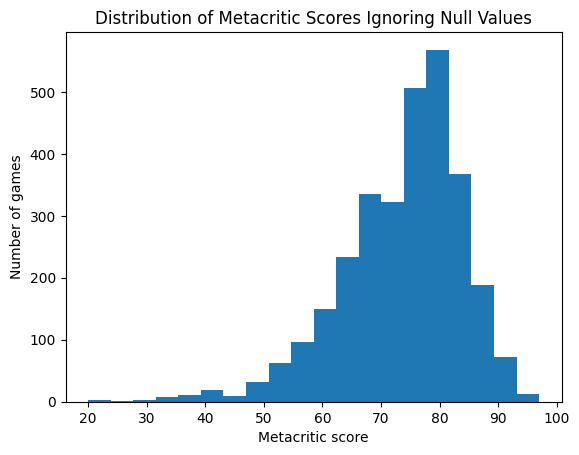

In [1361]:
plt.hist(info_base_games_df['metacritic'].dropna(), bins=20)
plt.xlabel("Metacritic score")
plt.ylabel("Number of games")
plt.title("Distribution of Metacritic Scores Ignoring Null Values")
plt.show()

The above histogram shows that the **metacritic scores are normally distributed**, which means **we can apply standardization on it**.

##### Metacritic scores before standardization

In [1362]:
info_base_games_df['metacritic'].dropna().head()

1893    84.0
5458    88.0
6519    76.0
6663    80.0
6862    75.0
Name: metacritic, dtype: float64

##### Standardizing metacritic scores

In [1363]:
standardizer = StandardScaler()
# IMPORTANT: later on I should fit_transform only on the training data
info_base_games_df['metacritic_preprocessed'] = standardizer.fit_transform(info_base_games_df[['metacritic']])

info_base_games_df['metacritic_preprocessed'].dropna().head()

1893    1.001252
5458    1.389238
6519    0.225281
6663    0.613267
6862    0.128285
Name: metacritic_preprocessed, dtype: float64

Now a problem remains, which is the missing values, it doesn't make sense to drop all the rows that don't contain a metacritic score since 97% of the data doesn't have it, the best solution that came to my mind is to **set all the NaN metacritic scores** to be equal to the **mean of the standardized metacritic scores**, which is **0**. And create a new boolean feature `has_metacritic` which indicates whether this game has a metacritic score or not, I hope that this can help models understand that if `has_metacritic = 0` then ignore this metacritic score, and also generally `has_metacritic` may later on turn out to be a useful feature on its own.

##### Creating New `has_metacritic` Feature

In [1364]:
info_base_games_df['has_metacritic'] = info_base_games_df['metacritic'].notna().astype(int)
print(info_base_games_df['has_metacritic'].head())
print(info_base_games_df['has_metacritic'].loc[[1893]])

0    0
1    0
2    0
3    0
4    0
Name: has_metacritic, dtype: int64
1893    1
Name: has_metacritic, dtype: int64


##### Replacing Missing Values With the Mean Value

Before

In [1365]:
info_base_games_df['metacritic_preprocessed'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: metacritic_preprocessed, dtype: float64

After

In [1366]:
info_base_games_df['metacritic_preprocessed'] = info_base_games_df['metacritic_preprocessed'].fillna(0)
print(info_base_games_df['metacritic_preprocessed'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: metacritic_preprocessed, dtype: float64


In [1367]:
info_base_games_df.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day,metacritic_preprocessed,has_metacritic
0,2574000,Femboy Burgers,NaN,1,True,True,"Casual, Indie",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.992222,0.124479,0.0,0
1,2574120,PPA Pickleball Tour 2025,NaN,1,True,True,"Indie, Simulation, Sports",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2024,-0.247022,-0.969010,0.0,0
2,2573200,Squeaky Squad,NaN,1,True,True,"Action, Adventure, Indie",0.060572,"['windows', 'mac', 'linux']",1,0.0,2024,0.998435,0.055917,0.0,0
3,2573440,Paradox Metal,NaN,1,True,True,"Action, Early Access",-0.000204,"['windows', 'mac', 'linux']",0,0.0,0,0.000000,0.000000,0.0,0
4,2569520,Naturpark Lillebælt VR,NaN,1,True,True,"Action, Adventure",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.972118,-0.234491,0.0,0


##### Final Thoughts On Preprocessing Metacritic

The above concludes my current trials to preprocess the metacritic column. I will leave below some thoughts that we may wish to revisit in the future:
1. I am not sure if the imputation technique that I used is the most suitable technique for this case, and I am not sure if it is correct to standardize then impute, or should I impute first then standardize, I chose the first approach since I think this will better maintain the distribution of the original data, and especially since I believe the imputed value shouldn't have any more meaning than just indicating that this row didn't have a metacritic value, which I tried to do along with the `has_metacritic` column.

2. Most importantly, I believe later on the `metacritic` column **will turn out to not be useful** for our models and that we will remove it as a feature, this is based on some discussions I read ([discussion1](https://Steamcommunity.com/discussions/forum/10/3057367211653181335/?l=latam), [discussion2](https://www.reddit.com/r/pcgaming/comments/1gjadpf/da_tv_metacritic_user_score_vs_Steam_ratings/)) in which multiple people feel that it doesn't give accurate reviews, I also expect that it might have a high correlation with `reviewScore` in `gamalytic_Steam_games.csv`, and considering that a small number of samples have this score, I expect this feature won't be useful, on the other hand, I believe we might find the new `has_metacritic` feature useful on its own, still this is all just speculations and we will find out by using proper feature selection methods.

#### Preprocessing The Genres Column

In [1368]:
info_base_games_df['genres'].head()

0                Casual, Indie
1    Indie, Simulation, Sports
2     Action, Adventure, Indie
3         Action, Early Access
4            Action, Adventure
Name: genres, dtype: object

##### Split Genres Into Lists

In [1369]:
info_base_games_df['genres_split'] = info_base_games_df['genres'].fillna('')
info_base_games_df['genres_split'] = info_base_games_df['genres_split'].apply(lambda x: x.split(', ') if x else [])
info_base_games_df['genres_split'].head()

0                [Casual, Indie]
1    [Indie, Simulation, Sports]
2     [Action, Adventure, Indie]
3         [Action, Early Access]
4            [Action, Adventure]
Name: genres_split, dtype: object

##### Analyze Genres

Flatten genres into one big list

In [1370]:
all_genres = [genre
              for sublist in info_base_games_df['genres_split']
              for genre in sublist]

Count genres frequencies

In [1371]:
genre_counts = Counter(all_genres)
genre_freq = (
    pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
      .sort_values('count', ascending=False)
)
print("Number of uniqure genres in the whole dataset:")
print(genre_freq.size)
print(genre_freq)

Number of uniqure genres in the whole dataset:
27
                       count
Indie                  66525
Action                 39986
Adventure              38977
Casual                 38195
Simulation             19738
Strategy               18979
RPG                    18960
Early Access            9989
Free To Play            8991
Sports                  3589
Racing                  3305
Massively Multiplayer   2542
Utilities                778
Design & Illustration    428
Animation & Modeling     348
Violent                  346
Education                319
Video Production         255
Game Development         251
Gore                     214
Audio Production         165
Software Training        152
Photo Editing            122
Web Publishing            85
Nudity                    76
Sexual Content            75
Accounting                19


Output word cloud for visualization of the genre counts

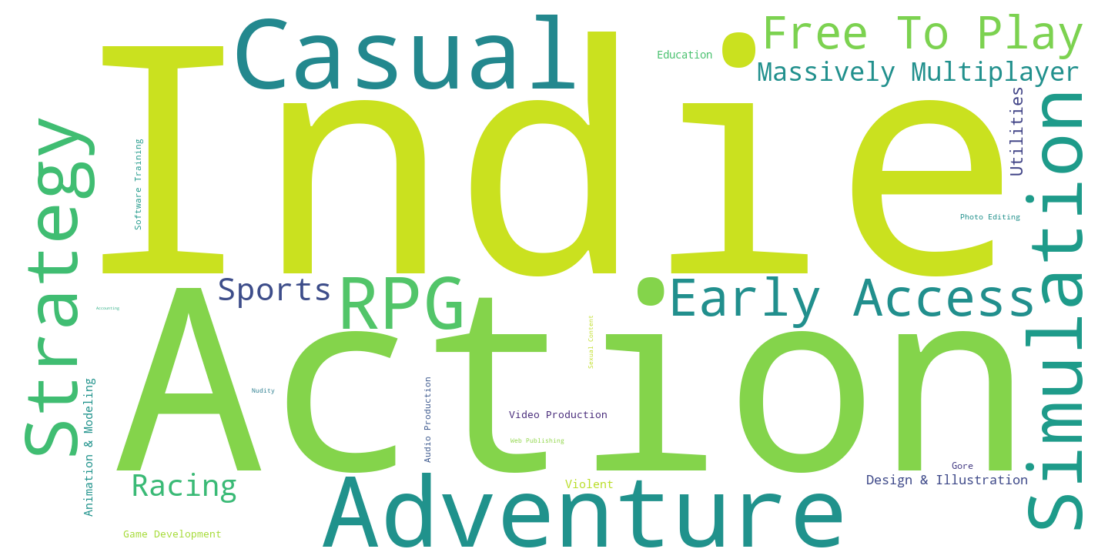

In [1372]:
wc = WordCloud(width=1400, height=700, background_color='white')
wc.generate_from_frequencies(genre_counts)

plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Multi-Hot Encode The Genres and Merge Them Into the Dataframe

In [1373]:
mlb = MultiLabelBinarizer()
# IMPORTANT: later on I should fit_transform only on the training data
genres_encoded = mlb.fit_transform(info_base_games_df['genres_split'])
genres_info_base_games_df = pd.DataFrame(genres_encoded, columns=[f'genre_{c}' for c in mlb.classes_], index=info_base_games_df.index)
info_base_games_df = pd.concat([info_base_games_df, genres_info_base_games_df], axis=1)
info_base_games_df = info_base_games_df.drop(columns=['genres_split'])

In [1374]:
pd.set_option('display.max_columns', None)
info_base_games_df.head()

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day,metacritic_preprocessed,has_metacritic,genre_Accounting,genre_Action,genre_Adventure,genre_Animation & Modeling,genre_Audio Production,genre_Casual,genre_Design & Illustration,genre_Early Access,genre_Education,genre_Free To Play,genre_Game Development,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Photo Editing,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Software Training,genre_Sports,genre_Strategy,genre_Utilities,genre_Video Production,genre_Violent,genre_Web Publishing
0,2574000,Femboy Burgers,NaN,1,True,True,"Casual, Indie",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.992222,0.124479,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2574120,PPA Pickleball Tour 2025,NaN,1,True,True,"Indie, Simulation, Sports",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2024,-0.247022,-0.969010,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,2573200,Squeaky Squad,NaN,1,True,True,"Action, Adventure, Indie",0.060572,"['windows', 'mac', 'linux']",1,0.0,2024,0.998435,0.055917,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2573440,Paradox Metal,NaN,1,True,True,"Action, Early Access",-0.000204,"['windows', 'mac', 'linux']",0,0.0,0,0.000000,0.000000,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2569520,Naturpark Lillebælt VR,NaN,1,True,True,"Action, Adventure",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.972118,-0.234491,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Final Thoughts On Preprocessing Genres

1. There are rare genres (Accounting, Nudity, Web Publishing, etc.), after research I believe we have 2 options that we can do with them, either treat them normally like all the other genres as I did above, or set a certain frequency threshold, and genres that have frequencies less than that threshold get removed and we replace them with a "genre_Other" column, I didn't do that since I have a feeling that these rare genres might help during prediction, but the best way to know would be to test both methods in the "training and evaluation" phase to determine which method helps the model make better predictions.

2. About handling unseen genres that we might get later on with unseen data, if we do not have the "genre_Other" column then the best way to handle them would be to ignore them, put 1's in the genres that we know, and ignore the ones we don't know, on the other hand if we have a "genre_Other" column, then we would put a 1 at that column.

3. If later on the genres prove to be useful in predictions and we select them as a feature, I believe the best way to handle them being missing in unseen data would be to webscrape and get the genres of the game.

4. Can later on try creating a new feature which is `number_of_genres`

#### Preprocessing The Supported Platforms Column

##### Analyzing the column

In [1375]:
info_base_games_df['supported_platforms'].value_counts()

supported_platforms
['windows']                    69612
['windows', 'mac', 'linux']    18796
['windows', 'mac']              7314
['windows', 'linux']            3111
['mac']                           19
['linux']                          7
['mac', 'linux']                   1
Name: count, dtype: int64

##### Multi-Hot Encode The Supported Platforms and Merge Them Into the Dataframe

In [1376]:
# Safely convert the supported_platforms list into a python list
info_base_games_df['platforms_parsed'] = info_base_games_df['supported_platforms'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()
platforms_encoded = mlb.fit_transform(info_base_games_df['platforms_parsed'])
platforms_info_base_games_df = pd.DataFrame(platforms_encoded, columns=mlb.classes_, index=info_base_games_df.index)
info_base_games_df = pd.concat([info_base_games_df, platforms_info_base_games_df], axis=1)
info_base_games_df.drop(columns='platforms_parsed', inplace=True)

In [1377]:
# Print info_base_games_df.head() along with another column that contains a different combination of platforms
pd.concat([info_base_games_df.head(), info_base_games_df.loc[[21144]]])

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day,metacritic_preprocessed,has_metacritic,genre_Accounting,genre_Action,genre_Adventure,genre_Animation & Modeling,genre_Audio Production,genre_Casual,genre_Design & Illustration,genre_Early Access,genre_Education,genre_Free To Play,genre_Game Development,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Photo Editing,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Software Training,genre_Sports,genre_Strategy,genre_Utilities,genre_Video Production,genre_Violent,genre_Web Publishing,linux,mac,windows
0,2574000,Femboy Burgers,NaN,1,True,True,"Casual, Indie",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.992222,0.124479,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,2574120,PPA Pickleball Tour 2025,NaN,1,True,True,"Indie, Simulation, Sports",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2024,-0.247022,-0.969010,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1
2,2573200,Squeaky Squad,NaN,1,True,True,"Action, Adventure, Indie",0.060572,"['windows', 'mac', 'linux']",1,0.0,2024,0.998435,0.055917,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,2573440,Paradox Metal,NaN,1,True,True,"Action, Early Access",-0.000204,"['windows', 'mac', 'linux']",0,0.0,0,0.000000,0.000000,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
4,2569520,Naturpark Lillebælt VR,NaN,1,True,True,"Action, Adventure",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.972118,-0.234491,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
21144,2909940,Last Ride,NaN,0,False,False,"Casual, Indie",-0.121755,"['windows', 'mac']",1,0.0,2024,0.953681,-0.300820,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


### Preprocessing App id, Name and 3 Boolean Columns

##### Data Statistics

In [1378]:
info_base_games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98860 entries, 0 to 99166
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        98860 non-null  object 
 1   name                         98846 non-null  object 
 2   metacritic                   3004 non-null   float64
 3   steam_achievements           98860 non-null  int64  
 4   steam_trading_cards          98860 non-null  bool   
 5   workshop_support             98860 non-null  bool   
 6   genres                       94108 non-null  object 
 7   achievements_total           98860 non-null  float64
 8   supported_platforms          98860 non-null  object 
 9   is_release_date_known        98860 non-null  int64  
 10  is_upcoming                  98860 non-null  float64
 11  year                         98860 non-null  int64  
 12  sin_day                      98860 non-null  float64
 13  cos_day              

- Notice that appid, steam_achievements, steam_trading_cards and workshop_support, all have no NULL values
- name has some NULL values

##### Calculate percentage of missing names:

In [1379]:
missing_pct = info_base_games_df['name'].isna().mean() * 100
print(f"{missing_pct:.2f}% of games have no name")

0.01% of games have no name


- Since percentage is very low, rows with no names can be dropped with no real impact

##### drop rows with NULL value names

In [1380]:
original_length = len(info_base_games_df)
info_base_games_df.dropna(subset=['name'], inplace=True)

print(f"Dropped {original_length - len(info_base_games_df)} rows with missing names.")

Dropped 14 rows with missing names.


##### Preprocess names and add features derived from name that could be useful


Preprocess names
- To lowercase
- Strip punctuation


features derived from name
- Character count
- Word count
- Ratio of capital letters to total length
- Is a sequel 
- Has useful keywords like (vr, remaster, collector, edition, bundle, playtest)

In [1381]:
# Strip punctuation
info_base_games_df['name'] = info_base_games_df['name'].str.replace(r'[^\w\s]', '', regex=True)

# add character count and word count features
info_base_games_df['name_len'] = info_base_games_df['name'].str.len()
info_base_games_df['name_words'] = info_base_games_df['name'].str.split().str.len()

def cap_ratio(s):
    if not s:
        return 0
    upper_count = sum(1 for ch in s if ch.isupper())
    return upper_count / len(s)

# add caps ratio feature
info_base_games_df['name_cap_ratio'] = info_base_games_df['name'].apply(cap_ratio)

# transform all names to lowercase
info_base_games_df['name'] = info_base_games_df['name'].str.lower()

# check if game is a sequel and add is_sequel feature
roman_re = re.compile(r'\b(?:i{1,3}|iv|v|vi|vii|viii|ix|x)\b')
digit_re = re.compile(r'\b[2-9]\b')

info_base_games_df['is_sequel'] = (
    info_base_games_df['name'].str.contains(roman_re) |
    info_base_games_df['name'].str.contains(digit_re)
).astype(int)

# add useful keyword features
keywords = ['vr', 'remaster', 'collector', 'collection', 'edition', 'bundle', 'playtest']
for kw in keywords:
    info_base_games_df[f'name_has_{kw}'] = (
        info_base_games_df['name']
          .str.contains(fr'\b{kw}\b')
          .astype(int)
    )

info_base_games_df

,appid,name,metacritic,steam_achievements,steam_trading_cards,workshop_support,genres,achievements_total,supported_platforms,is_release_date_known,is_upcoming,year,sin_day,cos_day,metacritic_preprocessed,has_metacritic,genre_Accounting,genre_Action,genre_Adventure,genre_Animation & Modeling,genre_Audio Production,genre_Casual,genre_Design & Illustration,genre_Early Access,genre_Education,genre_Free To Play,genre_Game Development,genre_Gore,genre_Indie,genre_Massively Multiplayer,genre_Nudity,genre_Photo Editing,genre_RPG,genre_Racing,genre_Sexual Content,genre_Simulation,genre_Software Training,genre_Sports,genre_Strategy,genre_Utilities,genre_Video Production,genre_Violent,genre_Web Publishing,linux,mac,windows,name_len,name_words,name_cap_ratio,is_sequel,name_has_vr,name_has_remaster,name_has_collector,name_has_collection,name_has_edition,name_has_bundle,name_has_playtest
0,2574000,femboy burgers,NaN,1,True,True,"Casual, Indie",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.992222,0.124479,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,14,2,0.142857,0,0,0,0,0,0,0,0
1,2574120,ppa pickleball tour 2025,NaN,1,True,True,"Indie, Simulation, Sports",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2024,-0.247022,-0.969010,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,24,4,0.208333,0,0,0,0,0,0,0,0
2,2573200,squeaky squad,NaN,1,True,True,"Action, Adventure, Indie",0.060572,"['windows', 'mac', 'linux']",1,0.0,2024,0.998435,0.055917,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,13,2,0.153846,0,0,0,0,0,0,0,0
3,2573440,paradox metal,NaN,1,True,True,"Action, Early Access",-0.000204,"['windows', 'mac', 'linux']",0,0.0,0,0.000000,0.000000,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,13,2,0.153846,0,0,0,0,0,0,0,0
4,2569520,naturpark lillebælt vr,NaN,1,True,True,"Action, Adventure",-0.000204,"['windows', 'mac', 'linux']",1,0.0,2023,-0.972118,-0.234491,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,22,3,0.181818,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99162,1548850,six days in fallujah,NaN,1,False,False,"Action, Early Access",0.107842,['windows'],1,0.0,2023,0.179767,-0.983709,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,4,0.150000,0,0,0,0,0,0,0,0
99163,2478130,project survival working title,NaN,0,False,False,"Action, Adventure, RPG",-0.121755,['windows'],0,0.0,0,0.000000,0.000000,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,30,4,0.533333,0,0,0,0,0,0,0,0
99164,3272980,sirens well,NaN,1,False,False,"Action, Adventure",-0.000204,"['windows', 'linux']",0,0.0,0,0.000000,0.000000,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,11,2,0.181818,0,0,0,0,0,0,0,0
99165,2054150,tower defender vr last adventure,NaN,0,False,False,"Casual, Indie, RPG, Strategy",-0.121755,['windows'],1,0.0,2022,-0.094537,-0.995521,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,32,5,0.187500,0,1,0,0,0,0,0,0


Apply pretrained embeddings on names

In [1382]:
model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(info_base_games_df['name'].tolist())

emb_dim = embeddings.shape[1]
emb_cols = [f'name_emb_{i}' for i in range(emb_dim)]
emb_df = pd.DataFrame(embeddings, columns=emb_cols, index=info_base_games_df.index)
info_base_games_df = pd.concat([info_base_games_df, emb_df], axis=1)

Scale numeric features (optional depending on model's sensitivity to data scale)

In [1383]:
scale_cols = [
    'name_len', 'name_words', 'name_cap_ratio', 'is_sequel'
] + [f'name_has_{kw}' for kw in keywords]

scaler = StandardScaler()
info_base_games_df[scale_cols] = scaler.fit_transform(info_base_games_df[scale_cols])

##### Turn boolian columns into numeric

In [1384]:
info_base_games_df['steam_achievements'] = info_base_games_df['steam_achievements'].astype(int)
info_base_games_df['steam_trading_cards'] = info_base_games_df['steam_trading_cards'].astype(int)
info_base_games_df['workshop_support'] = info_base_games_df['workshop_support'].astype(int)

##### Save the preprocessed data

- Save the preprocessed data for testing and validation purposes.
- Add features to the info_base_games: 
    
    - Character count
    - Word count
    - Ratio of capital letters to total length
    - Is a sequel
    - Has useful keywords like (vr, remaster, collector, edition, bundle, playtest)
    - Name embedding

In [1385]:
#info_base_games_df.to_csv(INFO_BASE_GAMES_PATH, index=False)

##### Statistics After Preprocessing

In [1386]:
info_base_games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98846 entries, 0 to 99166
Columns: 441 entries, appid to name_emb_383
dtypes: float32(384), float64(17), int64(36), object(4)
memory usage: 188.5+ MB


##### Summary and Conclusion

- **Imported & cleaned**  
  - Installed and loaded `sentence-transformers`, `pandas`, `re`, and `StandardScaler`  
  - Read in `info_base_games.csv` and inspected column completeness  

- **Handled missing titles**  
  - Calculated missing‑name percentage and dropped rows (low impact)  

- **Engineered name features**  
  - Normalized titles (lowercase, no punctuation)  
  - **Character count** (`name_len`)  
  - **Word count** (`name_words`)  
  - **Capital‑letter ratio** (`name_cap_ratio`)  
  - **Sequel flag** (`is_sequel`) identified from standalone roman numerals or digits  
  - **Keyword flags** (`name_has_vr`, `name_has_remaster`, etc.)

- **Applied embeddings**  
  - Generated embedding vectors from `all-MiniLM-L6-v2` for each cleaned name  

- **Scaled & encoded**  
  - Standardized numeric features (`name_len`, `name_words`, `name_cap_ratio`, `is_sequel`, keyword flags)  
  - Converted boolean columns (`steam_achievements`, `steam_trading_cards`, `workshop_support`) into numeric 0/1  

- **Saved & validated**  
  - (Optional) Exported the preprocessed DataFrame into csv
  - Reviewed final schema and data types

- **Notes**

  - Scaling numeric features should be applied or ignored depending on the model type and sensitivity to scaling
  - `app_id` will most likely be dropped since it has no useful impact on sales

## Preprocessing Gamalytic CSV

### Preprocessing Price, Copies Sold and Reviews Columns

####  **Identify Columns That Contain a Single Value**
  - Columns that have a single observation or value are probably useless for modeling.

In [1387]:
# Check if column has a single value
print(1, len(unique(gamalytic_steam_games_df['price'])))
print(2, len(unique(gamalytic_steam_games_df['copiesSold'])))
print(3, len(unique(gamalytic_steam_games_df['reviewScore'])))

1 350
2 22474
3 99


In [1388]:
print(gamalytic_steam_games_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93338 entries, 0 to 93337
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   steamId         93338 non-null  int64  
 1   price           93338 non-null  float64
 2   copiesSold      93338 non-null  int64  
 3   publisherClass  93338 non-null  object 
 4   reviewScore     93338 non-null  int64  
 5   aiContent       0 non-null      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 4.3+ MB
None


#### **Check Duplicates**

In [1389]:
duplicates = gamalytic_steam_games_df.duplicated()
print("Any duplicates ?", duplicates.any())
print("Duplicate rows:\n", gamalytic_steam_games_df[duplicates])

Any duplicates ? False
Duplicate rows:
 Empty DataFrame
Columns: [steamId, price, copiesSold, publisherClass, reviewScore, aiContent]
Index: []


#### **Remove Duplicates**

In [1390]:
print(gamalytic_steam_games_df.shape)
# delete duplicate rows
gamalytic_steam_games_df.drop_duplicates(inplace = True)
print(gamalytic_steam_games_df.shape)

(93338, 6)
(93338, 6)


#### **Count Missing Values**

In [1391]:
print(gamalytic_steam_games_df[['price', 'copiesSold', 'reviewScore']].isna().sum())
# Count how many rows have copiesSold == 0
zero_sales = gamalytic_steam_games_df[gamalytic_steam_games_df['copiesSold'] == 0]
print(zero_sales)

price          0
copiesSold     0
reviewScore    0
dtype: int64
       steamId  price  copiesSold publisherClass  reviewScore  aiContent
93324   680880   5.99           0       Hobbyist            0        NaN
93325   842080  11.99           0       Hobbyist            0        NaN
93326   630130   3.99           0       Hobbyist            0        NaN
93327   778980   0.99           0       Hobbyist            0        NaN
93328   738230   4.99           0       Hobbyist            0        NaN
93329   713550   4.99           0       Hobbyist            0        NaN
93330   700050   0.99           0       Hobbyist            0        NaN
93331   679960   0.99           0       Hobbyist            0        NaN
93332   492100   2.99           0       Hobbyist            0        NaN
93333   582110   7.99           0       Hobbyist            0        NaN
93334   514510   9.99           0          Indie            0        NaN
93335   497380  14.99           0          Indie            

#### **Checking Inconsistent Values**
 - Checking for Negative Values

In [1392]:
# Check if any value is negative
negative_price = (gamalytic_steam_games_df['price'] < 0).any()
negative_copies = (gamalytic_steam_games_df['copiesSold'] < 0).any()
negative_review = (gamalytic_steam_games_df['reviewScore'] < 0).any()

print(f"Negative 'price' values: {negative_price}")
print(f"Negative 'copiesSold' values: {negative_copies}")
print(f"Negative 'reviewScore' values: {negative_review}")


Negative 'price' values: False
Negative 'copiesSold' values: False
Negative 'reviewScore' values: False


#### **gamalytic_steam_games_df Transformation**
 - Analyzing Skewness

In [1393]:
# Check initial skewness of distributions
print(f"Price skewness: {skew(gamalytic_steam_games_df['price']):.2f}")
print(f"CopiesSold skewness: {skew(gamalytic_steam_games_df['copiesSold']):.2f}")
print(f"reviewScore skewness: {skew(gamalytic_steam_games_df['reviewScore']):.2f}")

Price skewness: 31.17
CopiesSold skewness: 117.49
reviewScore skewness: -1.28


#### **Log Transformation For Skewed gamalytic_steam_games_df**

In [1394]:
# Apply log transformation to reduce skewness
gamalytic_steam_games_df['price'] = np.log1p(gamalytic_steam_games_df['price'])
gamalytic_steam_games_df['copiesSold'] = np.log1p(gamalytic_steam_games_df['copiesSold'])

#### **Handling Outliers in Review Scores**

In [1395]:
low = gamalytic_steam_games_df['reviewScore'].quantile(0.25)
high = gamalytic_steam_games_df['reviewScore'].quantile(0.75)
median = gamalytic_steam_games_df['reviewScore'].median()

gamalytic_steam_games_df.loc[gamalytic_steam_games_df['reviewScore'] < low, 'reviewScore'] = median
gamalytic_steam_games_df.loc[gamalytic_steam_games_df['reviewScore'] > high, 'reviewScore'] = high



#### **Check skewness after transformation**

In [1396]:
# Check skewness after outlier treatment
print("After outlier treatment:")
print(f"Price skewness: {skew(gamalytic_steam_games_df['price']):.2f}")
print(f"CopiesSold skewness: {skew(gamalytic_steam_games_df['copiesSold']):.2f}")
print(f"reviewScore skewness: {skew(gamalytic_steam_games_df['reviewScore']):.2f}")

After outlier treatment:
Price skewness: -0.03
CopiesSold skewness: 0.21
reviewScore skewness: -0.54


#### **Feature Scaling**

In [1397]:
scaler = StandardScaler()
gamalytic_steam_games_df[['price', 'copiesSold', 'reviewScore']] = scaler.fit_transform(
    gamalytic_steam_games_df[['price', 'copiesSold', 'reviewScore']]
)

#### **Feature Extraction**

In [1398]:
selected_features = gamalytic_steam_games_df[['price', 'copiesSold', 'reviewScore']]

#### **Feature Analysis**
 - Correlation Analysis

In [1399]:
# Calculate Pearson correlation between features
correlation = selected_features.corr()

correlation_with_target = correlation['copiesSold'].drop('copiesSold').sort_values(ascending = False)

print("Correlation with copiesSold:")
print(correlation_with_target.to_string())

Correlation with copiesSold:
price          0.071405
reviewScore   -0.091055


#### **Mutual Information Scores**

In [1400]:
# Calculate mutual information scores
mi_scores = mutual_info_regression(
    selected_features.drop(columns=['copiesSold']),
    selected_features['copiesSold']
)

# Create a gamalytic_steam_games_dfFrame for mutual information results
mi_results = pd.DataFrame({
    'Feature': selected_features.drop(columns = ['copiesSold']).columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending = False)

print("Mutual Information Scores:")
print(mi_results.to_string(index = False))




Mutual Information Scores:
    Feature  MI_Score
reviewScore  0.430766
      price  0.176757


#### **ANOVA F-values**

In [1401]:
# Calculate ANOVA F-values for feature importance
selector = SelectKBest(score_func = f_regression, k = 'all')
selector.fit(
    selected_features.drop(columns=['copiesSold']),
    selected_features['copiesSold']
)

# Create a gamalytic_steam_games_dfFrame for ANOVA results
anova_results = pd.DataFrame({
    'Feature': selected_features.drop(columns = ['copiesSold']).columns,
    'F_Value': selector.scores_
}).sort_values('F_Value', ascending = False)

print("ANOVA F-Values:")
print(anova_results.to_string(index = False))


ANOVA F-Values:
    Feature    F_Value
reviewScore 780.312602
      price 478.335014


#### **gamalytic_steam_games_df Visualization**

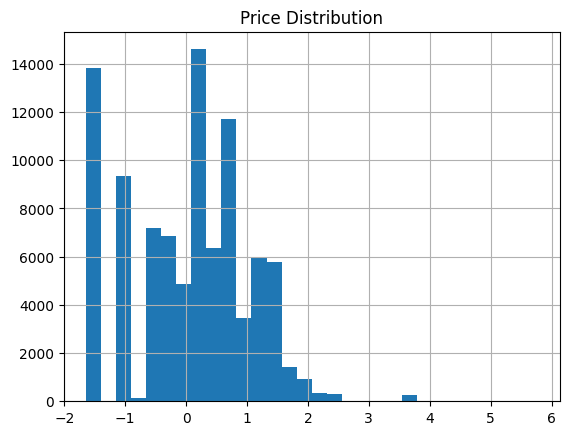

In [1402]:
# Visualize distribution of prices
gamalytic_steam_games_df['price'].hist(bins = 30)
plt.title('Price Distribution')
plt.show()


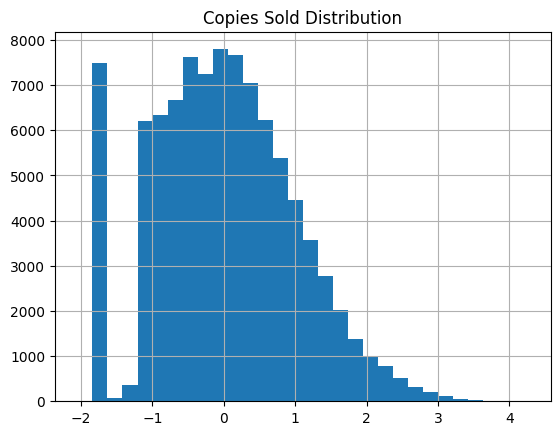

In [1403]:
# Visualize distribution of copiesSold
gamalytic_steam_games_df['copiesSold'].hist(bins = 30)
plt.title('Copies Sold Distribution')
plt.show()


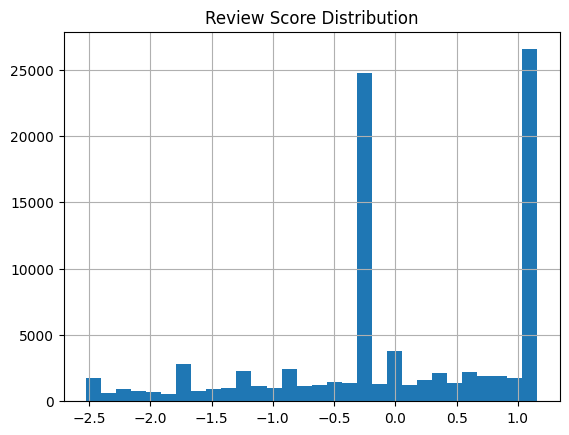

In [1404]:
# Visualize distribution of Review Score
gamalytic_steam_games_df['reviewScore'].hist(bins = 30)
plt.title('Review Score Distribution')
plt.show()


## Merge DataFrames

In [1405]:
gamalytic_steam_games_df.rename(columns={"steamId": "appid"}, inplace=True) # Temp Code until Mariam Code

# Ensure both DataFrames have the same data type for 'appid'
info_base_games_df['appid'] = info_base_games_df['appid'].astype(int)
gamalytic_steam_games_df['appid'] = gamalytic_steam_games_df['appid'].astype(int)

print("\nMerging DataFrames...")

# Merge info_base_games_df with gamalytic_steam_games_df into a new DataFrame
df = info_base_games_df.merge(gamalytic_steam_games_df, on="appid", how="inner")
print(f"Rows after gamalytic_steam_games_df merge: {len(df)}")

# Merge demo_indicators with df
df = df.merge(demo_indicators, on="appid", how="left")
print(f"Rows after demo_indicators merge: {len(df)}")

# Merge dlc_indicators with df
df = df.merge(dlc_indicators, on="appid", how="left")
print(f"Rows after dlc_indicators merge: {len(df)}")



Merging DataFrames...
Rows after gamalytic_steam_games_df merge: 69426
Rows after demo_indicators merge: 69426
Rows after dlc_indicators merge: 69426


## Handle Additional NaNs

In [1406]:
df["has_demo"] = df["has_demo"].fillna(0).astype(int)
df["demo_count"] = df["demo_count"].fillna(0).astype(int)
df["has_dlc"] = df["has_dlc"].fillna(0).astype(int)
df["dlc_count"] = df["dlc_count"].fillna(0).astype(int)

## Results

In [1407]:
# Check NaN counts after merging
print("\nSorted NaN counts after merge and imputation:")
nan_counts = df.isna().sum()
print(nan_counts[nan_counts > 0].sort_values(ascending=False))

print(f"\nRows after merge: {len(df)}")
print(df[["appid", "name", "metacritic_preprocessed", "has_metacritic", "achievements_total", "has_demo", "demo_count", "has_dlc", "dlc_count"]].head())


Sorted NaN counts after merge and imputation:
aiContent     69426
metacritic    66493
genres          104
dtype: int64

Rows after merge: 69426
     appid                      name  metacritic_preprocessed  has_metacritic  \
0  2574000            femboy burgers                      0.0               0   
1  2574120  ppa pickleball tour 2025                      0.0               0   
2  2573200             squeaky squad                      0.0               0   
3  2569520    naturpark lillebælt vr                      0.0               0   
4  2567670            a lively haunt                      0.0               0   

   achievements_total  has_demo  demo_count  has_dlc  dlc_count  
0           -0.000204         0           0        0          0  
1           -0.000204         0           0        0          0  
2            0.060572         0           0        0          0  
3           -0.000204         0           0        0          0  
4           -0.000204         0       

## Summary

In [1408]:
print("\nPreprocessing Summary:\n")
print(f"Final DataFrame: {len(df)} rows, {len(df.columns)} columns")


Preprocessing Summary:

Final DataFrame: 69426 rows, 450 columns


## Save The Final Dataframe to CSV

In [ ]:
# df.to_csv(OUTPUT_PATH, index=False)